In [2]:
# import warnings
# warnings.filterwarnings('ignore')

In [18]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import sparse
%matplotlib inline

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Amazon Employee Access Challenge

In [4]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [5]:
train.shape

(32769, 10)

In [6]:
test.shape

(58921, 10)

In [7]:
y_train = train['ACTION']

In [8]:
y_train.shape

(32769,)

In [9]:
train_data = train.drop('ACTION', axis=1)
train_data.shape

(32769, 9)

In [10]:
test_data = test.drop('id', axis=1)
test_data.shape

(58921, 9)

## Common Variables

In [11]:
# define variables
random_state = 42
cv = 5
scoring = 'roc_auc'
verbose=2

## Common functions

In [12]:
def save_submission(predictions, filename):
    global test
    submission = pd.DataFrame()
    submission["Id"] = test["id"]
    submission["ACTION"] = predictions
    filepath = "result/sampleSubmission_"+filename
    submission.to_csv(filepath, index = False)

In [13]:
def print_graph(results, param1, param2, xlabel, ylabel, title='Plot showing the ROC_AUC score for various hyper parameter values'):
    plt.plot(results[param1],results[param2]);
    plt.grid();
    plt.xlabel(xlabel);
    plt.ylabel(ylabel);
    plt.title(title);  

In [14]:
def get_rf_params():
    params = {
         'n_estimators':[10,20,50,100,200,500,700,1000],
         'max_depth':[1,2,5,10,12,15,20,25],
         'max_features':[1,2,3,4,5],
         'min_samples_split':[2,5,7,10,20]
    }

    return params

In [15]:
def get_xgb_params():
    params = {
        'n_estimators': [10,20,50,100,200,500,750,1000],
        'learning_rate': uniform(0.01, 0.6),
        'subsample': uniform(),
        'max_depth': [3, 4, 5, 6, 7, 8, 9],
        'colsample_bytree': uniform(),
        'min_child_weight': [1, 2, 3, 4]
    }
    
    return params

### We will try following models

1. KNN
2. SVM
3. Logistic Regression
4. Random Forest
5. Xgboost

## Build Models on the raw data

## 1.1 KNN with raw features

In [15]:
parameters={'n_neighbors':np.arange(1,100, 5)}
clf = RandomizedSearchCV(KNeighborsClassifier(n_jobs=-1),parameters,random_state=random_state,cv=cv,verbose=verbose,scoring=scoring,n_jobs=-1)
best_model = clf.fit(train_data,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   10.3s finished


In [16]:
results = pd.DataFrame.from_dict(best_model.cv_results_)
results=results.sort_values('param_n_neighbors')
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.096635,0.021398,0.281362,0.049282,1,{'n_neighbors': 1},0.613536,0.648565,0.631839,0.616312,0.612884,0.624627,0.013821,10
3,0.164077,0.032630,0.494310,0.086655,6,{'n_neighbors': 6},0.685658,0.705307,0.671377,0.682735,0.677139,0.684443,0.011522,1
7,0.225862,0.222115,0.760298,0.201853,16,{'n_neighbors': 16},0.682882,0.704267,0.671898,0.671661,0.688662,0.683874,0.012103,3
5,0.346801,0.212358,1.137279,0.157552,26,{'n_neighbors': 26},0.680836,0.702799,0.657414,0.686912,0.692020,0.683996,0.015120,2
4,0.200851,0.073359,1.428773,0.144754,41,{'n_neighbors': 41},0.679090,0.686315,0.660415,0.675779,0.679274,0.676175,0.008596,4
6,0.365463,0.173309,1.247004,0.159561,56,{'n_neighbors': 56},0.669826,0.680233,0.649829,0.677367,0.678156,0.671082,0.011194,5
2,0.410920,0.255036,1.443410,0.575523,76,{'n_neighbors': 76},0.661127,0.666859,0.647729,0.665512,0.667682,0.661782,0.007381,6
9,0.415716,0.077988,1.224522,0.280867,81,{'n_neighbors': 81},0.659469,0.661851,0.645727,0.664603,0.666253,0.659580,0.007305,7
1,0.159084,0.057097,1.449365,0.526592,86,{'n_neighbors': 86},0.660093,0.657713,0.645470,0.665596,0.662302,0.658235,0.006890,8
8,0.209846,0.161618,1.380716,0.146376,91,{'n_neighbors': 91},0.658300,0.655825,0.644015,0.663598,0.660646,0.656477,0.006740,9


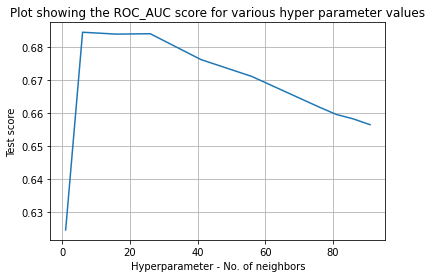

In [17]:
print_graph(results, 'param_n_neighbors', 'mean_test_score', 'Hyperparameter - No. of neighbors', 'Test score')  

In [18]:
best_c=best_model.best_params_['n_neighbors']
best_c

6

In [19]:
model = KNeighborsClassifier(n_neighbors=best_c,n_jobs=-1)
model.fit(train_data,y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=6)

In [20]:
predictions = model.predict_proba(test_data)[:,1]
save_submission(predictions, "knn_raw.csv")

## 1.2 SVM with raw feature

In [21]:
C_val = uniform(loc=0, scale=4)
model= LinearSVC(verbose=verbose,random_state=random_state,class_weight='balanced',max_iter=2000)
parameters={'C':C_val}
clf = RandomizedSearchCV(model,parameters,random_state=random_state,cv=cv,verbose=verbose,scoring=scoring,n_jobs=-1)
best_model = clf.fit(train_data,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.2min finished


[LibLinear]

/home/auw-mayank/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [22]:
best_c=best_model.best_params_['C']
best_c

1.49816047538945

In [23]:
results = pd.DataFrame.from_dict(best_model.cv_results_)
results=results.sort_values('param_C')
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,20.734650,0.347827,0.009492,0.000308,0.232334,{'C': 0.23233444867279784},0.521784,0.511453,0.513316,0.491307,0.518961,0.511364,0.010699,1
5,20.873183,0.386479,0.009743,0.000470,0.623978,{'C': 0.6239780813448106},0.521784,0.511453,0.513316,0.491307,0.518961,0.511364,0.010699,1
4,20.387018,0.315729,0.009394,0.000485,0.624075,{'C': 0.6240745617697461},0.521784,0.511453,0.513316,0.491307,0.518961,0.511364,0.010699,1
0,23.225106,0.465509,0.009646,0.000506,1.49816,{'C': 1.49816047538945},0.521784,0.511453,0.513316,0.491307,0.518961,0.511364,0.010699,1
3,20.659377,0.743686,0.009721,0.000884,2.39463,{'C': 2.3946339367881464},0.521784,0.511453,0.513316,0.491307,0.518961,0.511364,0.010699,1
8,21.443917,0.555311,0.009146,0.000541,2.40446,{'C': 2.404460046972835},0.521784,0.511453,0.513316,0.491307,0.518961,0.511364,0.010699,1
9,15.863019,6.075852,0.006511,0.001712,2.83229,{'C': 2.832290311184182},0.521784,0.511453,0.513316,0.491307,0.518961,0.511364,0.010699,1
2,20.339319,0.350078,0.009859,0.002029,2.92798,{'C': 2.9279757672456204},0.521784,0.511453,0.513316,0.491307,0.518961,0.511364,0.010699,1
7,20.729889,0.605134,0.009491,0.000308,3.4647,{'C': 3.4647045830997407},0.521784,0.511453,0.513316,0.491307,0.518961,0.511364,0.010699,1
1,22.079217,1.212271,0.009619,0.000485,3.80286,{'C': 3.8028572256396647},0.521784,0.511453,0.513316,0.491307,0.518961,0.511364,0.010699,1


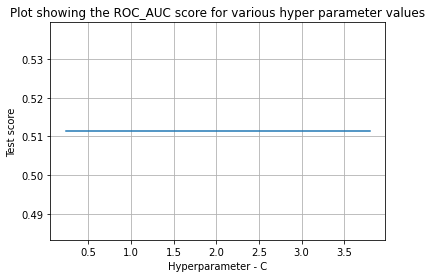

In [24]:
print_graph(results, 'param_C', 'mean_test_score', 'Hyperparameter - C', 'Test score')

In [25]:
#https://stackoverflow.com/questions/26478000/converting-linearsvcs-decision-function-to-probabilities-scikit-learn-python
model = LinearSVC(C=best_c,verbose=verbose,random_state=random_state,class_weight='balanced',max_iter=2000)
model = CalibratedClassifierCV(model)
model.fit(train_data,y_train)

[LibLinear]

/home/auw-mayank/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/home/auw-mayank/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/home/auw-mayank/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/home/auw-mayank/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear]

/home/auw-mayank/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


CalibratedClassifierCV(base_estimator=LinearSVC(C=1.49816047538945,
                                                class_weight='balanced',
                                                max_iter=2000, random_state=42,
                                                verbose=2))

In [26]:
predictions = model.predict_proba(test_data)[:,1]
save_submission(predictions, 'svm_raw.csv')

## 1.3 Logistic Regression with Raw Feature

In [27]:
C_val = uniform(loc=0, scale=4)
lr= LogisticRegression(verbose=verbose,random_state=random_state,class_weight='balanced',solver='lbfgs',max_iter=500,n_jobs=-1)
parameters={'C':C_val}
clf = RandomizedSearchCV(lr,parameters,random_state=random_state,cv=cv,verbose=verbose,n_iter=100,scoring=scoring,n_jobs=-1)
best_model = clf.fit(train_data,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   21.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


In [28]:
best_c=best_model.best_params_['C']
best_c

1.49816047538945

In [29]:
results = pd.DataFrame.from_dict(best_model.cv_results_)
results=results.sort_values('param_C')
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
72,0.288207,0.049340,0.009709,0.001088,0.0220885,{'C': 0.022088468494409597},0.519329,0.548037,0.516881,0.53325,0.498591,0.523217,0.016604,1
10,0.308069,0.038586,0.008474,0.000245,0.082338,{'C': 0.08233797718320979},0.519328,0.548037,0.516881,0.53325,0.498591,0.523217,0.016604,99
98,0.296427,0.044889,0.007660,0.001223,0.101677,{'C': 0.10167650697638075},0.519328,0.548037,0.516881,0.53325,0.498591,0.523217,0.016604,99
42,0.327696,0.038082,0.009636,0.001287,0.137554,{'C': 0.13755408446087358},0.519329,0.548037,0.516881,0.53325,0.498591,0.523217,0.016604,1
58,0.326322,0.043709,0.009740,0.001623,0.180909,{'C': 0.18090915564215226},0.519329,0.548037,0.516881,0.53325,0.498591,0.523217,0.016604,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,0.366390,0.056284,0.012254,0.002800,3.80286,{'C': 3.8028572256396647},0.519329,0.548037,0.516881,0.53325,0.498591,0.523217,0.016604,1
34,0.330722,0.064558,0.009515,0.001008,3.86253,{'C': 3.8625281322982374},0.519329,0.548037,0.516881,0.53325,0.498591,0.523217,0.016604,1
50,0.289553,0.048755,0.008182,0.001069,3.87834,{'C': 3.8783385110582342},0.519329,0.548037,0.516881,0.53325,0.498591,0.523217,0.016604,1
11,0.275883,0.051927,0.009324,0.001304,3.87964,{'C': 3.8796394086479773},0.519329,0.548037,0.516881,0.53325,0.498591,0.523217,0.016604,1


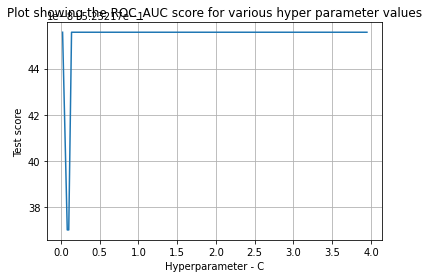

In [30]:
print_graph(results, 'param_C', 'mean_test_score', 'Hyperparameter - C', 'Test score')

In [31]:
model = LogisticRegression(C=best_c,verbose=verbose,n_jobs=-1,random_state=random_state,class_weight='balanced',solver='lbfgs')
model.fit(train_data,y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


LogisticRegression(C=1.49816047538945, class_weight='balanced', n_jobs=-1,
                   random_state=42, verbose=2)

In [32]:
predictions = model.predict_proba(test_data)[:,1]
save_submission(predictions, 'lr_raw.csv')

## 1.4 Random Forest with Raw Feature

In [33]:
rfc = RandomForestClassifier(random_state=random_state,class_weight='balanced',n_jobs=-1)
clf = RandomizedSearchCV(rfc,get_rf_params(),random_state=random_state,cv=cv,verbose=verbose,n_iter=100,scoring=scoring,n_jobs=-1)
best_model = clf.fit(train_data,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   24.2s
/home/auw-mayank/.local/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 15.5min finished


In [35]:
results = pd.DataFrame(best_model.cv_results_)
results.sort_values('mean_test_score',ascending=False,inplace=True)
param_keys=['param_'+str(each) for each in get_rf_params().keys()]
param_keys.append('mean_test_score')
results[param_keys].head(10)

,param_n_estimators,param_max_depth,param_max_features,param_min_samples_split,mean_test_score
78,700,25,2,7,0.864035
62,500,25,3,5,0.862868
79,500,25,1,10,0.861580
55,200,25,2,5,0.860777
22,200,25,4,10,0.860643
20,1000,25,3,2,0.860467
85,1000,20,3,7,0.860057
33,700,25,4,2,0.859027
84,1000,25,5,2,0.858752
27,50,25,2,10,0.858280


In [36]:
n_estimators=clf.best_params_['n_estimators']
max_features=clf.best_params_['max_features']
max_depth=clf.best_params_['max_depth']
min_samples_split=clf.best_params_['min_samples_split']
n_estimators,max_features,max_depth,min_samples_split

(700, 2, 25, 7)

In [37]:
model=RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,max_features=max_features,
                             min_samples_split=min_samples_split,
                             random_state=random_state,class_weight='balanced',n_jobs=-1)

model.fit(train_data,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=25, max_features=2,
                       min_samples_split=7, n_estimators=700, n_jobs=-1,
                       random_state=42)

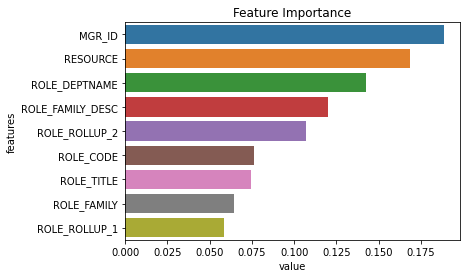

In [40]:
features=train_data.columns
importance=model.feature_importances_
features=pd.DataFrame({'features':features,'value':importance})
features=features.sort_values('value',ascending=False)
sns.barplot('value','features',data=features);
plt.title('Feature Importance');

In [41]:
predictions = model.predict_proba(test_data)[:,1]
save_submission(predictions, 'rf_raw.csv')

## 1.5 Xgboost with Raw Feature

In [45]:
xgb = XGBClassifier()
clf = RandomizedSearchCV(xgb,get_xgb_params(),random_state=random_state,cv=cv,verbose=verbose,n_iter=100,scoring=scoring,n_jobs=-1)
best_model=clf.fit(train_data,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  7.0min finished


In [48]:
results = pd.DataFrame(best_model.cv_results_)
results.sort_values('mean_test_score',ascending=False,inplace=True)
param_keys=['param_'+str(each) for each in get_xgb_params().keys()]
param_keys.append('mean_test_score')
results[param_keys].head(10)

,param_n_estimators,param_learning_rate,param_subsample,param_max_depth,param_colsample_bytree,param_min_child_weight,mean_test_score
18,1000,0.048135,0.665922,9,0.330898,2,0.859879
44,1000,0.060484,0.606429,6,0.642032,2,0.855594
97,750,0.232385,0.907694,6,0.374271,1,0.855062
96,500,0.0979629,0.98664,7,0.891897,1,0.854603
62,500,0.0663892,0.328153,9,0.375583,3,0.851305
49,500,0.160277,0.393098,8,0.636333,2,0.851109
84,200,0.571989,0.967581,6,0.348337,1,0.850137
53,200,0.540096,0.928319,6,0.27956,1,0.849858
86,1000,0.475848,0.858413,9,0.372018,2,0.849704
8,750,0.0686033,0.683264,6,0.304614,4,0.846364


In [50]:
colsample_bytree = clf.best_params_['colsample_bytree']
learning_rate=clf.best_params_['learning_rate']
max_depth=clf.best_params_['max_depth']
min_child_weight=clf.best_params_['min_child_weight']
n_estimators=clf.best_params_['n_estimators']
subsample=clf.best_params_['subsample']
colsample_bytree,learning_rate,max_depth,min_child_weight,n_estimators,subsample

(0.3308980248526492, 0.04813501017161418, 9, 2, 1000, 0.6659223566174967)

In [51]:
model = XGBClassifier(colsample_bytree=colsample_bytree,learning_rate=learning_rate,max_depth=max_depth,
                     min_child_weight=min_child_weight,n_estimators=n_estimators,subsample=subsample,n_jobs=-1)

model.fit(train_data,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3308980248526492, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.04813501017161418, max_delta_step=0, max_depth=9,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.6659223566174967, tree_method='exact',
              validate_parameters=1, verbosity=None)

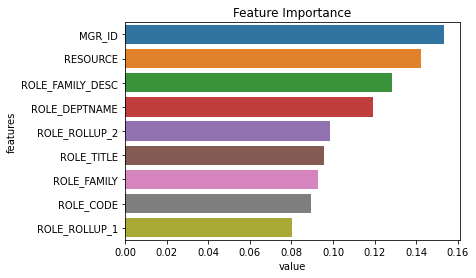

In [53]:
features=train_data.columns
importance=model.feature_importances_
features=pd.DataFrame({'features':features,'value':importance})
features=features.sort_values('value',ascending=False)
sns.barplot('value','features',data=features);
plt.title('Feature Importance');

In [54]:
predictions = model.predict_proba(test_data)[:,1]
save_submission(predictions, 'xgb_raw.csv')

## Build model on one hot encoded features

### 2.1 KNN with one hot encoded features

In [19]:
train_ohe = sparse.load_npz('data/train_ohe.npz')
test_ohe = sparse.load_npz('data/test_ohe.npz')

train_ohe.shape, test_ohe.shape, y_train.shape

((32769, 4500), (58921, 4500), (32769,))

In [20]:
parameters={'n_neighbors':np.arange(1,100, 5)}
clf = RandomizedSearchCV(KNeighborsClassifier(n_jobs=-1),parameters,random_state=random_state,cv=cv,verbose=verbose,scoring=scoring,n_jobs=4)
best_model = clf.fit(train_ohe,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  2.4min finished


In [21]:
results = pd.DataFrame.from_dict(best_model.cv_results_)
results=results.sort_values('param_n_neighbors')
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006555,0.000700,10.645058,0.929198,1,{'n_neighbors': 1},0.637669,0.648976,0.623238,0.636597,0.657423,0.640781,0.011654,10
3,0.016959,0.004260,10.951772,0.202645,6,{'n_neighbors': 6},0.772541,0.817724,0.780078,0.764374,0.793066,0.785556,0.018651,7
7,0.009756,0.002644,10.934812,0.238815,16,{'n_neighbors': 16},0.799350,0.826579,0.798793,0.807640,0.819408,0.810354,0.011021,1
5,0.012228,0.004394,11.793501,0.161717,26,{'n_neighbors': 26},0.797242,0.823686,0.803639,0.801732,0.815795,0.808419,0.009798,2
4,0.009644,0.001508,11.796731,0.637320,41,{'n_neighbors': 41},0.793851,0.818524,0.801002,0.788353,0.802746,0.800895,0.010209,3
6,0.008616,0.001666,11.293223,0.298707,56,{'n_neighbors': 56},0.786070,0.817701,0.795020,0.780427,0.797255,0.795294,0.012744,4
2,0.008984,0.001381,11.413321,0.929274,76,{'n_neighbors': 76},0.787624,0.812770,0.781610,0.774486,0.792079,0.789714,0.012955,5
9,0.016020,0.009590,9.739804,2.040784,81,{'n_neighbors': 81},0.784840,0.807796,0.781348,0.773990,0.789062,0.787407,0.011329,6
1,0.009150,0.001799,12.091294,0.740555,86,{'n_neighbors': 86},0.781589,0.804704,0.778055,0.770839,0.784661,0.783969,0.011344,8
8,0.009462,0.001561,11.527709,0.549754,91,{'n_neighbors': 91},0.776625,0.803739,0.776098,0.768254,0.785209,0.781985,0.012129,9


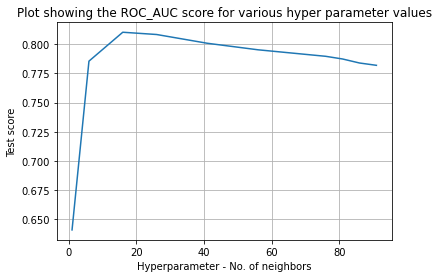

In [22]:
print_graph(results, 'param_n_neighbors', 'mean_test_score', 'Hyperparameter - No. of neighbors', 'Test score')  

In [23]:
best_c=best_model.best_params_['n_neighbors']
best_c

16

In [24]:
model = KNeighborsClassifier(n_neighbors=best_c,n_jobs=-1)
model.fit(train_ohe,y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=16)

In [25]:
predictions = model.predict_proba(test_ohe)[:,1]
save_submission(predictions, "knn_ohe.csv")

## 2.2 SVM with one hot encoded features

In [26]:
C_val = uniform(loc=0, scale=4)
model= LinearSVC(verbose=verbose,random_state=random_state,class_weight='balanced',max_iter=2000)
parameters={'C':C_val}
clf = RandomizedSearchCV(model,parameters,random_state=random_state,cv=cv,verbose=verbose,scoring=scoring,n_jobs=-1)
best_model = clf.fit(train_ohe,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   27.4s finished


[LibLinear]

In [27]:
best_c=best_model.best_params_['C']
best_c

0.23233444867279784

In [28]:
results = pd.DataFrame.from_dict(best_model.cv_results_)
results=results.sort_values('param_C')
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,1.665692,0.108757,0.006313,0.001323,0.232334,{'C': 0.23233444867279784},0.875975,0.877388,0.868423,0.854196,0.876759,0.870548,0.008795,1
5,3.346733,0.146270,0.006011,0.000766,0.623978,{'C': 0.6239780813448106},0.863449,0.867204,0.859359,0.839469,0.866949,0.859286,0.010310,2
4,3.379395,0.230067,0.005820,0.000426,0.624075,{'C': 0.6240745617697461},0.863445,0.867202,0.859356,0.839466,0.866949,0.859284,0.010310,3
0,5.286501,0.285730,0.006386,0.000235,1.49816,{'C': 1.49816047538945},0.853168,0.859763,0.849378,0.826701,0.858361,0.849474,0.011976,4
3,4.842430,0.183511,0.005510,0.000145,2.39463,{'C': 2.3946339367881464},0.847499,0.855500,0.843579,0.820130,0.854114,0.844165,0.012780,5
8,4.411906,0.514393,0.005908,0.001863,2.40446,{'C': 2.404460046972835},0.847479,0.855422,0.843511,0.820026,0.854117,0.844111,0.012805,6
9,3.920161,0.269418,0.003479,0.000145,2.83229,{'C': 2.832290311184182},0.845397,0.853960,0.841066,0.817675,0.852844,0.842189,0.013150,7
2,4.567836,0.304712,0.005663,0.000212,2.92798,{'C': 2.9279757672456204},0.845317,0.853648,0.840564,0.817211,0.852536,0.841855,0.013222,8
7,4.717893,0.223145,0.005428,0.000025,3.4647,{'C': 3.4647045830997407},0.843165,0.852070,0.838012,0.815041,0.851000,0.839857,0.013443,9
1,4.484730,0.265796,0.006122,0.000613,3.80286,{'C': 3.8028572256396647},0.841944,0.851182,0.836607,0.813757,0.850197,0.838738,0.013602,10


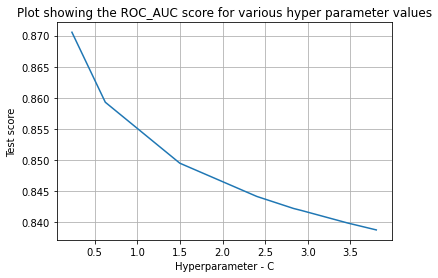

In [29]:
print_graph(results, 'param_C', 'mean_test_score', 'Hyperparameter - C', 'Test score')

In [30]:
#https://stackoverflow.com/questions/26478000/converting-linearsvcs-decision-function-to-probabilities-scikit-learn-python
model = LinearSVC(C=best_c,verbose=verbose,random_state=random_state,class_weight='balanced',max_iter=2000)
model = CalibratedClassifierCV(model)
model.fit(train_ohe,y_train)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

CalibratedClassifierCV(base_estimator=LinearSVC(C=0.23233444867279784,
                                                class_weight='balanced',
                                                max_iter=2000, random_state=42,
                                                verbose=2))

In [31]:
predictions = model.predict_proba(test_ohe)[:,1]
save_submission(predictions, 'svm_ohe.csv')

## 2.3 Logistic Regression with one hot encoded features

In [32]:
C_val = uniform(loc=0, scale=4)
lr= LogisticRegression(verbose=verbose,random_state=random_state,class_weight='balanced',solver='lbfgs',max_iter=500,n_jobs=-1)
parameters={'C':C_val}
clf = RandomizedSearchCV(lr,parameters,random_state=random_state,cv=cv,verbose=verbose,n_iter=100,scoring=scoring,n_jobs=-1)
best_model = clf.fit(train_ohe,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished


In [33]:
best_c=best_model.best_params_['C']
best_c

0.6820964947491661

In [34]:
results = pd.DataFrame.from_dict(best_model.cv_results_)
results=results.sort_values('param_C')
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
72,0.402010,0.039785,0.007355,0.001598,0.0220885,{'C': 0.022088468494409597},0.829685,0.826673,0.806216,0.819296,0.846943,0.825763,0.013332,100
10,0.614088,0.059061,0.007151,0.001726,0.082338,{'C': 0.08233797718320979},0.865434,0.864914,0.844665,0.850616,0.871585,0.859443,0.010095,99
98,0.813808,0.043571,0.010610,0.005761,0.101677,{'C': 0.10167650697638075},0.869131,0.868748,0.848990,0.854158,0.874163,0.863038,0.009692,98
42,0.772666,0.046637,0.015021,0.005916,0.137554,{'C': 0.13755408446087358},0.873619,0.873387,0.854562,0.858294,0.877240,0.867420,0.009155,97
58,0.912758,0.067513,0.007433,0.000250,0.180909,{'C': 0.18090915564215226},0.876668,0.876799,0.858603,0.861092,0.879451,0.870523,0.008808,88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,2.179010,0.046898,0.006497,0.000748,3.80286,{'C': 3.8028572256396647},0.875063,0.877224,0.867324,0.852923,0.878666,0.870240,0.009502,92
34,2.533670,0.089338,0.006896,0.000663,3.86253,{'C': 3.8625281322982374},0.874952,0.877128,0.867242,0.852755,0.878560,0.870127,0.009524,93
50,2.387026,0.082491,0.007058,0.001786,3.87834,{'C': 3.8783385110582342},0.874918,0.877105,0.867222,0.852722,0.878531,0.870099,0.009525,94
11,2.207417,0.122827,0.005258,0.000889,3.87964,{'C': 3.8796394086479773},0.874916,0.877106,0.867214,0.852707,0.878524,0.870093,0.009530,95


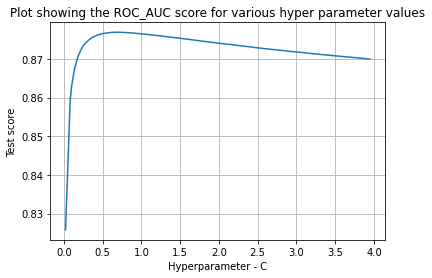

In [35]:
print_graph(results, 'param_C', 'mean_test_score', 'Hyperparameter - C', 'Test score')

In [36]:
model = LogisticRegression(C=best_c,verbose=verbose,n_jobs=-1,random_state=random_state,class_weight='balanced',solver='lbfgs')
model.fit(train_ohe,y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s finished


LogisticRegression(C=0.6820964947491661, class_weight='balanced', n_jobs=-1,
                   random_state=42, verbose=2)

In [37]:
predictions = model.predict_proba(test_ohe)[:,1]
save_submission(predictions, 'lr_ohe.csv')

## 2.4 Random Forest with one hot encoded features

In [38]:
rfc = RandomForestClassifier(random_state=random_state,class_weight='balanced',n_jobs=-1)
clf = RandomizedSearchCV(rfc,get_rf_params(),random_state=random_state,cv=cv,verbose=verbose,n_iter=100,scoring=scoring,n_jobs=-1)
best_model = clf.fit(train_ohe,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.6min finished


In [39]:
results = pd.DataFrame(best_model.cv_results_)
results.sort_values('mean_test_score',ascending=False,inplace=True)
param_keys=['param_'+str(each) for each in get_rf_params().keys()]
param_keys.append('mean_test_score')
results[param_keys].head(10)

,param_n_estimators,param_max_depth,param_max_features,param_min_samples_split,mean_test_score
78,700,25,2,7,0.860722
85,1000,20,3,7,0.855874
62,500,25,3,5,0.851481
6,500,20,2,5,0.850966
11,1000,15,3,7,0.849860
25,700,15,4,7,0.842645
19,700,15,4,5,0.841873
22,200,25,4,10,0.840912
79,500,25,1,10,0.840153
82,700,20,5,20,0.839475


In [40]:
n_estimators=clf.best_params_['n_estimators']
max_features=clf.best_params_['max_features']
max_depth=clf.best_params_['max_depth']
min_samples_split=clf.best_params_['min_samples_split']
n_estimators,max_features,max_depth,min_samples_split

(700, 2, 25, 7)

In [41]:
model=RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,max_features=max_features,
                             min_samples_split=min_samples_split,
                             random_state=random_state,class_weight='balanced',n_jobs=-1)

model.fit(train_ohe,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=25, max_features=2,
                       min_samples_split=7, n_estimators=700, n_jobs=-1,
                       random_state=42)

In [44]:
# features=train_ohe.columns
# importance=model.feature_importances_
# features=pd.DataFrame({'features':features,'value':importance})
# features=features.sort_values('value',ascending=False)
# sns.barplot('value','features',data=features);
# plt.title('Feature Importance');

In [45]:
predictions = model.predict_proba(test_ohe)[:,1]
save_submission(predictions, 'rf_ohe.csv')

## 2.5 Xgboost with one hot encoded features

In [46]:
xgb = XGBClassifier()
clf = RandomizedSearchCV(xgb,get_xgb_params(),random_state=random_state,cv=cv,verbose=verbose,n_iter=100,scoring=scoring,n_jobs=-1)
best_model=clf.fit(train_ohe,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  7.5min finished


In [47]:
results = pd.DataFrame(best_model.cv_results_)
results.sort_values('mean_test_score',ascending=False,inplace=True)
param_keys=['param_'+str(each) for each in get_xgb_params().keys()]
param_keys.append('mean_test_score')
results[param_keys].head(10)

,param_n_estimators,param_learning_rate,param_subsample,param_max_depth,param_colsample_bytree,param_min_child_weight,mean_test_score
97,750,0.232385,0.907694,6,0.374271,1,0.846718
80,1000,0.385564,0.905351,3,0.820639,1,0.845197
86,1000,0.475848,0.858413,9,0.372018,2,0.843883
84,200,0.571989,0.967581,6,0.348337,1,0.841967
14,200,0.374221,0.802197,7,0.965255,1,0.841475
50,500,0.388683,0.645103,4,0.892047,1,0.837885
53,200,0.540096,0.928319,6,0.27956,1,0.836996
92,200,0.478778,0.49442,9,0.946195,1,0.835709
96,500,0.0979629,0.98664,7,0.891897,1,0.835223
22,1000,0.391846,0.695516,6,0.0314292,1,0.833849


In [48]:
colsample_bytree = clf.best_params_['colsample_bytree']
learning_rate=clf.best_params_['learning_rate']
max_depth=clf.best_params_['max_depth']
min_child_weight=clf.best_params_['min_child_weight']
n_estimators=clf.best_params_['n_estimators']
subsample=clf.best_params_['subsample']
colsample_bytree,learning_rate,max_depth,min_child_weight,n_estimators,subsample

(0.3742707957561203, 0.23238528824013455, 6, 1, 750, 0.9076937063485463)

In [49]:
model = XGBClassifier(colsample_bytree=colsample_bytree,learning_rate=learning_rate,max_depth=max_depth,
                     min_child_weight=min_child_weight,n_estimators=n_estimators,subsample=subsample,n_jobs=-1)

model.fit(train_ohe,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3742707957561203, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.23238528824013455, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=750, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.9076937063485463, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [51]:
# features=train_ohe.columns
# importance=model.feature_importances_
# features=pd.DataFrame({'features':features,'value':importance})
# features=features.sort_values('value',ascending=False)
# sns.barplot('value','features',data=features);
# plt.title('Feature Importance');

In [52]:
predictions = model.predict_proba(test_ohe)[:,1]
save_submission(predictions, 'xgb_ohe.csv')

# 3 Build Model on frequency encoding feature

## 3.1 KNN with frequency encoding

In [56]:
train_df_fc = pd.read_csv('data/train_df_fc.csv')
test_df_fc = pd.read_csv('data/test_df_fc.csv')

In [58]:
train_df_fc.shape, test_df_fc.shape, y_train.shape

((32769, 9), (58921, 9), (32769,))

In [59]:
parameters={'n_neighbors':np.arange(1,100, 5)}
clf = RandomizedSearchCV(KNeighborsClassifier(n_jobs=-1),parameters,random_state=random_state,cv=cv,verbose=verbose,scoring=scoring,n_jobs=-1)
best_model = clf.fit(train_df_fc,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.9s finished


In [60]:
results = pd.DataFrame.from_dict(best_model.cv_results_)
results=results.sort_values('param_n_neighbors')
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.991111,0.183696,0.397176,0.059816,1,{'n_neighbors': 1},0.689830,0.699702,0.672487,0.691981,0.683082,0.687416,0.009157,10
3,0.879315,0.135934,0.458961,0.077771,6,{'n_neighbors': 6},0.782603,0.801378,0.779351,0.785807,0.789640,0.787756,0.007617,2
7,0.884993,0.122899,0.551275,0.019701,16,{'n_neighbors': 16},0.780617,0.810798,0.788244,0.793029,0.784501,0.791438,0.010514,1
5,0.835931,0.085821,0.602055,0.034525,26,{'n_neighbors': 26},0.784436,0.799879,0.773578,0.792340,0.781795,0.786406,0.009016,3
4,0.843408,0.175449,0.541291,0.046475,41,{'n_neighbors': 41},0.764873,0.782251,0.762178,0.783043,0.763852,0.771240,0.009357,4
6,0.777994,0.179328,0.703416,0.074496,56,{'n_neighbors': 56},0.749887,0.769348,0.757223,0.767120,0.757640,0.760244,0.007118,5
2,0.873574,0.084183,0.783552,0.094332,76,{'n_neighbors': 76},0.735012,0.749768,0.748032,0.750562,0.756848,0.748045,0.007165,6
9,0.859934,0.169601,0.597329,0.176583,81,{'n_neighbors': 81},0.733258,0.745024,0.744657,0.746431,0.756481,0.745170,0.007372,7
1,0.945682,0.208584,0.812918,0.093525,86,{'n_neighbors': 86},0.731535,0.740285,0.741123,0.741903,0.755343,0.742038,0.007632,8
8,0.742842,0.139272,0.847516,0.096580,91,{'n_neighbors': 91},0.730638,0.735961,0.738581,0.739851,0.753802,0.739767,0.007697,9


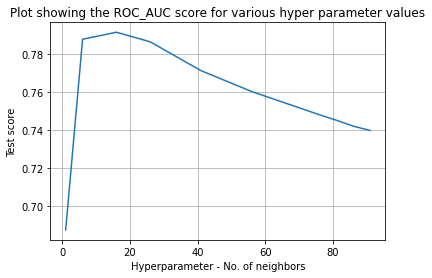

In [61]:
print_graph(results, 'param_n_neighbors', 'mean_test_score', 'Hyperparameter - No. of neighbors', 'Test score')  

In [62]:
best_c=best_model.best_params_['n_neighbors']
best_c

16

In [63]:
model = KNeighborsClassifier(n_neighbors=best_c,n_jobs=-1)
model.fit(train_df_fc,y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=16)

In [64]:
predictions = model.predict_proba(test_df_fc)[:,1]
save_submission(predictions, "knn_fc.csv")

## 3.2 SVM with frequency encoding

In [65]:
C_val = uniform(loc=0, scale=4)
model= LinearSVC(verbose=verbose,random_state=random_state,class_weight='balanced',max_iter=2000)
parameters={'C':C_val}
clf = RandomizedSearchCV(model,parameters,random_state=random_state,cv=cv,verbose=verbose,scoring=scoring,n_jobs=-1)
best_model = clf.fit(train_df_fc,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   31.1s finished


[LibLinear]

In [66]:
best_c=best_model.best_params_['C']
best_c

3.4647045830997407

In [67]:
results = pd.DataFrame.from_dict(best_model.cv_results_)
results=results.sort_values('param_C')
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,0.660086,0.017374,0.008614,0.000488,0.232334,{'C': 0.23233444867279784},0.596242,0.592806,0.589267,0.589870,0.616262,0.596889,0.009998,10
5,1.545461,0.046888,0.008634,0.000531,0.623978,{'C': 0.6239780813448106},0.598835,0.598629,0.594103,0.590754,0.618887,0.600242,0.009797,8
4,1.520200,0.027312,0.008497,0.000279,0.624075,{'C': 0.6240745617697461},0.598836,0.598628,0.594102,0.590755,0.618887,0.600242,0.009797,9
0,3.399906,0.065053,0.008735,0.000205,1.49816,{'C': 1.49816047538945},0.599720,0.603314,0.596806,0.590896,0.619533,0.602054,0.009639,7
3,5.481297,0.139391,0.008909,0.001057,2.39463,{'C': 2.3946339367881464},0.599911,0.604767,0.597368,0.590228,0.619655,0.602386,0.009829,5
8,5.338629,0.086250,0.009277,0.001996,2.40446,{'C': 2.404460046972835},0.599903,0.604776,0.597367,0.590224,0.619659,0.602386,0.009832,6
9,5.073023,0.532082,0.005769,0.001041,2.83229,{'C': 2.832290311184182},0.600041,0.605195,0.597402,0.590054,0.619668,0.602472,0.009889,4
2,6.768211,0.148776,0.008396,0.000148,2.92798,{'C': 2.9279757672456204},0.600091,0.605287,0.597393,0.590013,0.619653,0.602487,0.009897,3
7,8.421839,0.690331,0.011411,0.006144,3.4647,{'C': 3.4647045830997407},0.600137,0.605531,0.597598,0.589721,0.619510,0.602500,0.009914,1
1,9.505879,0.670729,0.008447,0.000100,3.80286,{'C': 3.8028572256396647},0.600128,0.605674,0.597598,0.589540,0.619514,0.602491,0.009972,2


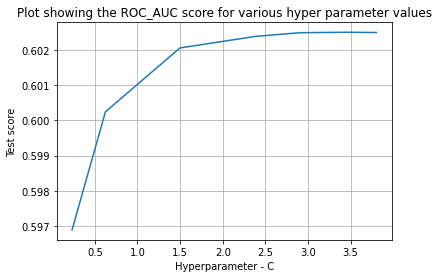

In [68]:
print_graph(results, 'param_C', 'mean_test_score', 'Hyperparameter - C', 'Test score')

In [69]:
#https://stackoverflow.com/questions/26478000/converting-linearsvcs-decision-function-to-probabilities-scikit-learn-python
model = LinearSVC(C=best_c,verbose=verbose,random_state=random_state,class_weight='balanced',max_iter=2000)
model = CalibratedClassifierCV(model)
model.fit(train_df_fc,y_train)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

CalibratedClassifierCV(base_estimator=LinearSVC(C=3.4647045830997407,
                                                class_weight='balanced',
                                                max_iter=2000, random_state=42,
                                                verbose=2))

In [70]:
predictions = model.predict_proba(test_df_fc)[:,1]
save_submission(predictions, 'svm_fc.csv')

## 3.3 Logistic Regression with frequency encoding

In [71]:
C_val = uniform(loc=0, scale=4)
lr= LogisticRegression(verbose=verbose,random_state=random_state,class_weight='balanced',solver='lbfgs',max_iter=500,n_jobs=-1)
parameters={'C':C_val}
clf = RandomizedSearchCV(lr,parameters,random_state=random_state,cv=cv,verbose=verbose,n_iter=100,scoring=scoring,n_jobs=-1)
best_model = clf.fit(train_df_fc,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   27.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


In [72]:
best_c=best_model.best_params_['C']
best_c

3.947547746402069

In [73]:
results = pd.DataFrame.from_dict(best_model.cv_results_)
results=results.sort_values('param_C')
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
72,0.228973,0.004824,0.010685,0.001596,0.0220885,{'C': 0.022088468494409597},0.572784,0.564601,0.561810,0.579600,0.592248,0.574209,0.010978,100
10,0.234010,0.017427,0.007461,0.002247,0.082338,{'C': 0.08233797718320979},0.576081,0.570211,0.569417,0.584004,0.590101,0.577963,0.008006,99
98,0.229021,0.005651,0.009482,0.001367,0.101677,{'C': 0.10167650697638075},0.578311,0.571484,0.571928,0.586633,0.590390,0.579749,0.007644,98
42,0.229497,0.003935,0.009067,0.001537,0.137554,{'C': 0.13755408446087358},0.581972,0.574516,0.576192,0.590778,0.591770,0.583046,0.007166,97
58,0.279884,0.048332,0.010730,0.002777,0.180909,{'C': 0.18090915564215226},0.586059,0.577597,0.579853,0.593481,0.593861,0.586170,0.006723,96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,0.463957,0.082331,0.011337,0.004639,3.80286,{'C': 3.8028572256396647},0.597920,0.597220,0.592827,0.590501,0.618289,0.599351,0.009860,5
34,0.464361,0.038105,0.008287,0.001417,3.86253,{'C': 3.8625281322982374},0.597984,0.597303,0.592888,0.590481,0.618319,0.599395,0.009862,4
50,0.552498,0.041888,0.013899,0.005771,3.87834,{'C': 3.8783385110582342},0.597974,0.597336,0.592937,0.590487,0.618339,0.599415,0.009861,3
11,0.447006,0.048351,0.010926,0.002407,3.87964,{'C': 3.8796394086479773},0.598001,0.597354,0.592944,0.590463,0.618329,0.599418,0.009859,2


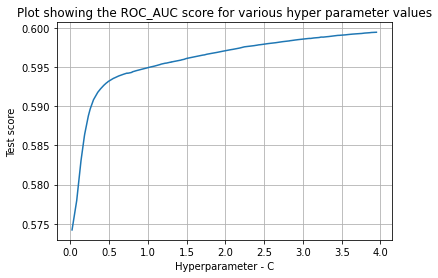

In [74]:
print_graph(results, 'param_C', 'mean_test_score', 'Hyperparameter - C', 'Test score')

In [75]:
model = LogisticRegression(C=best_c,verbose=verbose,n_jobs=-1,random_state=random_state,class_weight='balanced',solver='lbfgs')
model.fit(train_df_fc,y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished


LogisticRegression(C=3.947547746402069, class_weight='balanced', n_jobs=-1,
                   random_state=42, verbose=2)

In [76]:
predictions = model.predict_proba(test_df_fc)[:,1]
save_submission(predictions, 'lr_fc.csv')

## 3.4 Random Forest with frequency encoding

In [77]:
rfc = RandomForestClassifier(random_state=random_state,class_weight='balanced',n_jobs=-1)
clf = RandomizedSearchCV(rfc,get_rf_params(),random_state=random_state,cv=cv,verbose=verbose,n_iter=100,scoring=scoring,n_jobs=-1)
best_model = clf.fit(train_df_fc,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  8.7min
/home/auw-mayank/.local/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 12.9min finished


In [78]:
results = pd.DataFrame(best_model.cv_results_)
results.sort_values('mean_test_score',ascending=False,inplace=True)
param_keys=['param_'+str(each) for each in get_rf_params().keys()]
param_keys.append('mean_test_score')
results[param_keys].head(10)

,param_n_estimators,param_max_depth,param_max_features,param_min_samples_split,mean_test_score
78,700,25,2,7,0.865455
79,500,25,1,10,0.863705
85,1000,20,3,7,0.863124
55,200,25,2,5,0.862767
27,50,25,2,10,0.862615
62,500,25,3,5,0.862305
22,200,25,4,10,0.862143
6,500,20,2,5,0.860599
76,50,25,1,5,0.859855
84,1000,25,5,2,0.859026


In [79]:
n_estimators=clf.best_params_['n_estimators']
max_features=clf.best_params_['max_features']
max_depth=clf.best_params_['max_depth']
min_samples_split=clf.best_params_['min_samples_split']
n_estimators,max_features,max_depth,min_samples_split

(700, 2, 25, 7)

In [80]:
model=RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,max_features=max_features,
                             min_samples_split=min_samples_split,
                             random_state=random_state,class_weight='balanced',n_jobs=-1)

model.fit(train_df_fc,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=25, max_features=2,
                       min_samples_split=7, n_estimators=700, n_jobs=-1,
                       random_state=42)

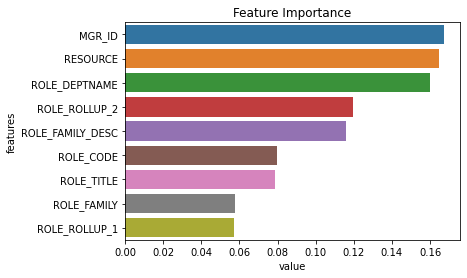

In [81]:
features=train_df_rc.columns
importance=model.feature_importances_
features=pd.DataFrame({'features':features,'value':importance})
features=features.sort_values('value',ascending=False)
sns.barplot('value','features',data=features);
plt.title('Feature Importance');

In [82]:
predictions = model.predict_proba(test_df_fc)[:,1]
save_submission(predictions, 'rf_fc.csv')

## 3.5 Xgboost with frequency encoding

In [83]:
xgb = XGBClassifier()
clf = RandomizedSearchCV(xgb,get_xgb_params(),random_state=random_state,cv=cv,verbose=verbose,n_iter=100,scoring=scoring,n_jobs=-1)
best_model=clf.fit(train_df_fc,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  7.0min finished


In [84]:
results = pd.DataFrame(best_model.cv_results_)
results.sort_values('mean_test_score',ascending=False,inplace=True)
param_keys=['param_'+str(each) for each in get_xgb_params().keys()]
param_keys.append('mean_test_score')
results[param_keys].head(10)

,param_n_estimators,param_learning_rate,param_subsample,param_max_depth,param_colsample_bytree,param_min_child_weight,mean_test_score
18,1000,0.048135,0.665922,9,0.330898,2,0.858830
96,500,0.0979629,0.98664,7,0.891897,1,0.857160
44,1000,0.060484,0.606429,6,0.642032,2,0.854864
97,750,0.232385,0.907694,6,0.374271,1,0.854471
86,1000,0.475848,0.858413,9,0.372018,2,0.852575
53,200,0.540096,0.928319,6,0.27956,1,0.851643
84,200,0.571989,0.967581,6,0.348337,1,0.850900
49,500,0.160277,0.393098,8,0.636333,2,0.850151
62,500,0.0663892,0.328153,9,0.375583,3,0.848839
14,200,0.374221,0.802197,7,0.965255,1,0.846264


In [85]:
colsample_bytree = clf.best_params_['colsample_bytree']
learning_rate=clf.best_params_['learning_rate']
max_depth=clf.best_params_['max_depth']
min_child_weight=clf.best_params_['min_child_weight']
n_estimators=clf.best_params_['n_estimators']
subsample=clf.best_params_['subsample']
colsample_bytree,learning_rate,max_depth,min_child_weight,n_estimators,subsample

(0.3308980248526492, 0.04813501017161418, 9, 2, 1000, 0.6659223566174967)

In [86]:
model = XGBClassifier(colsample_bytree=colsample_bytree,learning_rate=learning_rate,max_depth=max_depth,
                     min_child_weight=min_child_weight,n_estimators=n_estimators,subsample=subsample,n_jobs=-1)

model.fit(train_df_fc,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.3308980248526492, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.04813501017161418, max_delta_step=0, max_depth=9,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.6659223566174967, tree_method='exact',
              validate_parameters=1, verbosity=None)

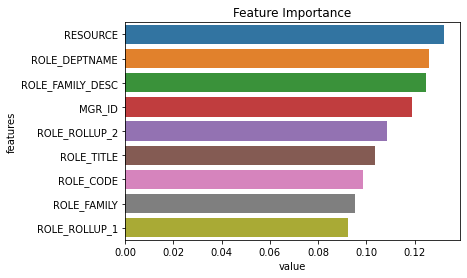

In [87]:
features=train_df_rc.columns
importance=model.feature_importances_
features=pd.DataFrame({'features':features,'value':importance})
features=features.sort_values('value',ascending=False)
sns.barplot('value','features',data=features);
plt.title('Feature Importance');

In [88]:
predictions = model.predict_proba(test_df_fc)[:,1]
save_submission(predictions, 'xgb_fc.csv')

# 4 Build Model using response encoding feature

In [89]:
train_df_rc = pd.read_csv('data/train_df_rc.csv')
test_df_rc = pd.read_csv('data/test_df_rc.csv')

In [90]:
train_df_rc.shape, test_df_rc.shape, y_train.shape

((32769, 9), (58921, 9), (32769,))

## 4.1 KNN with response encoding

In [91]:
parameters={'n_neighbors':np.arange(1,100, 5)}
clf = RandomizedSearchCV(KNeighborsClassifier(n_jobs=-1),parameters,random_state=random_state,cv=cv,verbose=verbose,scoring=scoring,n_jobs=-1)
best_model = clf.fit(train_df_rc,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    9.9s finished


In [92]:
results = pd.DataFrame.from_dict(best_model.cv_results_)
results=results.sort_values('param_n_neighbors')
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.086230,0.005424,0.344790,0.070813,1,{'n_neighbors': 1},0.785764,0.803724,0.775463,0.779148,0.764597,0.781739,0.012958,10
3,0.213144,0.076467,0.614406,0.058540,6,{'n_neighbors': 6},0.913267,0.929281,0.912042,0.938589,0.930850,0.924806,0.010417,9
7,0.310182,0.147531,0.762474,0.161863,16,{'n_neighbors': 16},0.947662,0.957579,0.950075,0.960931,0.948791,0.953008,0.005266,8
5,0.331806,0.120254,0.966461,0.082860,26,{'n_neighbors': 26},0.960510,0.965995,0.956449,0.965414,0.956676,0.961009,0.004101,7
4,0.232953,0.077137,1.056732,0.093508,41,{'n_neighbors': 41},0.967694,0.970531,0.961577,0.970235,0.962889,0.966585,0.003711,6
6,0.229306,0.095399,1.410068,0.127344,56,{'n_neighbors': 56},0.968329,0.971504,0.963187,0.970208,0.966776,0.968001,0.002896,5
2,0.274036,0.120750,1.699503,0.340801,76,{'n_neighbors': 76},0.969092,0.970238,0.965122,0.970237,0.968003,0.968538,0.001900,3
9,0.296290,0.185593,1.379694,0.639957,81,{'n_neighbors': 81},0.969085,0.970350,0.964951,0.969905,0.967942,0.968447,0.001930,4
1,0.173163,0.121023,1.987021,0.248016,86,{'n_neighbors': 86},0.968902,0.971091,0.965033,0.969832,0.967886,0.968549,0.002051,2
8,0.191794,0.042695,2.263545,0.085086,91,{'n_neighbors': 91},0.968775,0.970906,0.964625,0.970507,0.968111,0.968585,0.002237,1


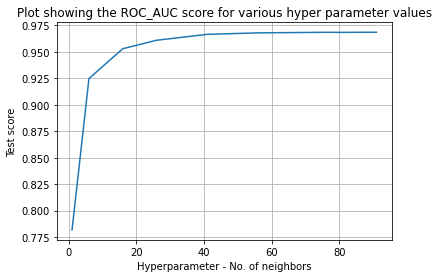

In [93]:
print_graph(results, 'param_n_neighbors', 'mean_test_score', 'Hyperparameter - No. of neighbors', 'Test score')  

In [94]:
best_c=best_model.best_params_['n_neighbors']
best_c

91

In [95]:
model = KNeighborsClassifier(n_neighbors=best_c,n_jobs=-1)
model.fit(train_df_rc,y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=91)

In [96]:
predictions = model.predict_proba(test_df_rc)[:,1]
save_submission(predictions, "knn_rc.csv")

## 4.2 SVM with response encoding

In [97]:
C_val = uniform(loc=0, scale=4)
model= LinearSVC(verbose=verbose,random_state=random_state,class_weight='balanced',max_iter=2000)
parameters={'C':C_val}
clf = RandomizedSearchCV(model,parameters,random_state=random_state,cv=cv,verbose=verbose,scoring=scoring,n_jobs=-1)
best_model = clf.fit(train_df_rc,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   53.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.5min finished


[LibLinear]

In [98]:
best_c=best_model.best_params_['C']
best_c

0.23233444867279784

In [99]:
results = pd.DataFrame.from_dict(best_model.cv_results_)
results=results.sort_values('param_C')
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,3.183277,0.033934,0.009042,0.000496,0.232334,{'C': 0.23233444867279784},0.962693,0.968227,0.956840,0.961949,0.960551,0.962052,0.003687,1
5,8.848153,0.747037,0.008727,0.000209,0.623978,{'C': 0.6239780813448106},0.962731,0.968228,0.956767,0.961982,0.960510,0.962044,0.003713,3
4,8.912073,0.494012,0.009330,0.001017,0.624075,{'C': 0.6240745617697461},0.962731,0.968228,0.956767,0.961982,0.960510,0.962044,0.003713,2
0,17.408767,0.154881,0.009085,0.000893,1.49816,{'C': 1.49816047538945},0.962746,0.968237,0.956698,0.962003,0.960470,0.962031,0.003739,5
3,17.469577,0.150116,0.009678,0.001768,2.39463,{'C': 2.3946339367881464},0.962758,0.968233,0.956696,0.962007,0.960461,0.962031,0.003739,4
8,16.938676,1.437584,0.008894,0.001664,2.40446,{'C': 2.404460046972835},0.962758,0.968232,0.956696,0.962007,0.960461,0.962031,0.003739,6
9,14.780462,1.392490,0.005426,0.000718,2.83229,{'C': 2.832290311184182},0.962760,0.968226,0.956688,0.962006,0.960461,0.962028,0.003740,7
2,18.095028,0.436138,0.009675,0.002155,2.92798,{'C': 2.9279757672456204},0.962761,0.968228,0.956687,0.962003,0.960458,0.962027,0.003741,9
7,18.129031,0.448210,0.009041,0.000252,3.4647,{'C': 3.4647045830997407},0.962761,0.968228,0.956687,0.962009,0.960453,0.962028,0.003741,8
1,18.158810,0.237538,0.008929,0.000369,3.80286,{'C': 3.8028572256396647},0.962760,0.968227,0.956680,0.962013,0.960450,0.962026,0.003743,10


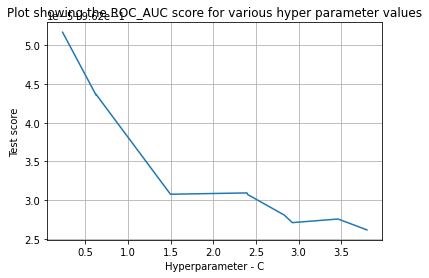

In [100]:
print_graph(results, 'param_C', 'mean_test_score', 'Hyperparameter - C', 'Test score')

In [101]:
#https://stackoverflow.com/questions/26478000/converting-linearsvcs-decision-function-to-probabilities-scikit-learn-python
model = LinearSVC(C=best_c,verbose=verbose,random_state=random_state,class_weight='balanced',max_iter=2000)
model = CalibratedClassifierCV(model)
model.fit(train_df_rc,y_train)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

CalibratedClassifierCV(base_estimator=LinearSVC(C=0.23233444867279784,
                                                class_weight='balanced',
                                                max_iter=2000, random_state=42,
                                                verbose=2))

In [102]:
predictions = model.predict_proba(test_df_rc)[:,1]
save_submission(predictions, 'svm_rc.csv')

## 4.3 Logistic Regression with response encoding

In [103]:
C_val = uniform(loc=0, scale=4)
lr= LogisticRegression(verbose=verbose,random_state=random_state,class_weight='balanced',solver='lbfgs',max_iter=500,n_jobs=-1)
parameters={'C':C_val}
clf = RandomizedSearchCV(lr,parameters,random_state=random_state,cv=cv,verbose=verbose,n_iter=100,scoring=scoring,n_jobs=-1)
best_model = clf.fit(train_df_rc,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   33.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s finished


In [104]:
best_c=best_model.best_params_['C']
best_c

3.8783385110582342

In [105]:
results = pd.DataFrame.from_dict(best_model.cv_results_)
results=results.sort_values('param_C')
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
72,0.327374,0.006836,0.011249,0.002206,0.0220885,{'C': 0.022088468494409597},0.961174,0.966541,0.953542,0.960469,0.958646,0.960074,0.004193,100
10,0.349562,0.045889,0.015735,0.008208,0.082338,{'C': 0.08233797718320979},0.962000,0.967349,0.954943,0.961462,0.959433,0.961037,0.004016,99
98,0.397482,0.052807,0.013315,0.005191,0.101677,{'C': 0.10167650697638075},0.962099,0.967475,0.955163,0.961613,0.959566,0.961183,0.003987,98
42,0.375170,0.046277,0.011422,0.002756,0.137554,{'C': 0.13755408446087358},0.962232,0.967616,0.955462,0.961811,0.959706,0.961365,0.003940,97
58,0.408102,0.080918,0.011763,0.002735,0.180909,{'C': 0.18090915564215226},0.962303,0.967719,0.955701,0.961930,0.959816,0.961494,0.003898,96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,0.553916,0.074240,0.012201,0.002789,3.80286,{'C': 3.8028572256396647},0.962708,0.968389,0.956652,0.962017,0.960447,0.962042,0.003803,2
34,0.451665,0.092593,0.012936,0.001691,3.86253,{'C': 3.8625281322982374},0.962709,0.968388,0.956649,0.962019,0.960447,0.962042,0.003804,3
50,0.537376,0.136078,0.013254,0.004744,3.87834,{'C': 3.8783385110582342},0.962709,0.968387,0.956652,0.962019,0.960449,0.962043,0.003803,1
11,0.542682,0.102528,0.014036,0.000457,3.87964,{'C': 3.8796394086479773},0.962705,0.968389,0.956641,0.962018,0.960449,0.962040,0.003806,7


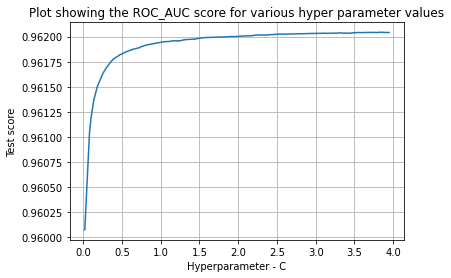

In [106]:
print_graph(results, 'param_C', 'mean_test_score', 'Hyperparameter - C', 'Test score')

In [107]:
model = LogisticRegression(C=best_c,verbose=verbose,n_jobs=-1,random_state=random_state,class_weight='balanced',solver='lbfgs')
model.fit(train_df_rc,y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.5s finished


LogisticRegression(C=3.8783385110582342, class_weight='balanced', n_jobs=-1,
                   random_state=42, verbose=2)

In [108]:
predictions = model.predict_proba(test_df_rc)[:,1]
save_submission(predictions, 'lr_rc.csv')

## 4.4 Random Forest with response encoding

In [109]:
rfc = RandomForestClassifier(random_state=random_state,class_weight='balanced',n_jobs=-1)
clf = RandomizedSearchCV(rfc,get_rf_params(),random_state=random_state,cv=cv,verbose=verbose,n_iter=100,scoring=scoring,n_jobs=-1)
best_model = clf.fit(train_df_rc,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 10.1min finished


In [110]:
results = pd.DataFrame(best_model.cv_results_)
results.sort_values('mean_test_score',ascending=False,inplace=True)
param_keys=['param_'+str(each) for each in get_rf_params().keys()]
param_keys.append('mean_test_score')
results[param_keys].head(10)

,param_n_estimators,param_max_depth,param_max_features,param_min_samples_split,mean_test_score
68,1000,10,4,20,0.978213
26,700,12,4,20,0.978080
64,700,10,5,7,0.977829
82,700,20,5,20,0.977748
41,500,10,3,7,0.977430
96,100,10,3,10,0.977397
87,200,10,5,2,0.977377
11,1000,15,3,7,0.977211
85,1000,20,3,7,0.977043
25,700,15,4,7,0.976876


In [111]:
n_estimators=clf.best_params_['n_estimators']
max_features=clf.best_params_['max_features']
max_depth=clf.best_params_['max_depth']
min_samples_split=clf.best_params_['min_samples_split']
n_estimators,max_features,max_depth,min_samples_split

(1000, 4, 10, 20)

In [112]:
model=RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,max_features=max_features,
                             min_samples_split=min_samples_split,
                             random_state=random_state,class_weight='balanced',n_jobs=-1)

model.fit(train_df_rc,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=4,
                       min_samples_split=20, n_estimators=1000, n_jobs=-1,
                       random_state=42)

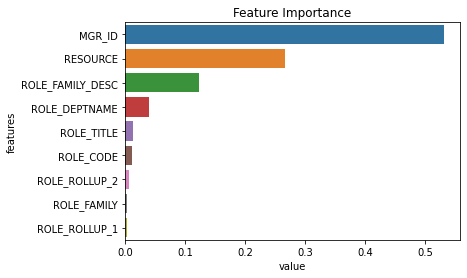

In [113]:
features=train_df_rc.columns
importance=model.feature_importances_
features=pd.DataFrame({'features':features,'value':importance})
features=features.sort_values('value',ascending=False)
sns.barplot('value','features',data=features);
plt.title('Feature Importance');

In [114]:
predictions = model.predict_proba(test_df_rc)[:,1]
save_submission(predictions, 'rf_rc.csv')

## 4.5 Xgboost with response encoding

In [115]:
xgb = XGBClassifier()
clf = RandomizedSearchCV(xgb,get_xgb_params(),random_state=random_state,cv=cv,verbose=verbose,n_iter=100,scoring=scoring,n_jobs=-1)
best_model=clf.fit(train_df_rc,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  7.5min finished


In [116]:
results = pd.DataFrame(best_model.cv_results_)
results.sort_values('mean_test_score',ascending=False,inplace=True)
param_keys=['param_'+str(each) for each in get_xgb_params().keys()]
param_keys.append('mean_test_score')
results[param_keys].head(10)

,param_n_estimators,param_learning_rate,param_subsample,param_max_depth,param_colsample_bytree,param_min_child_weight,mean_test_score
1,200,0.0699849,0.601115,5,0.445833,4,0.980332
28,500,0.0141713,0.222108,5,0.860731,1,0.980097
7,500,0.017959,0.808397,3,0.450499,4,0.980070
98,50,0.220131,0.777147,6,0.591889,3,0.979997
41,20,0.34312,0.996254,6,0.817222,1,0.979949
58,50,0.454461,0.708911,3,0.877373,1,0.979929
33,100,0.153737,0.447783,4,0.908266,1,0.979679
74,20,0.432195,0.763364,6,0.855461,4,0.979671
94,20,0.591191,0.618218,3,0.705831,2,0.979554
88,200,0.307937,0.895523,3,0.534327,2,0.979545


In [117]:
colsample_bytree = clf.best_params_['colsample_bytree']
learning_rate=clf.best_params_['learning_rate']
max_depth=clf.best_params_['max_depth']
min_child_weight=clf.best_params_['min_child_weight']
n_estimators=clf.best_params_['n_estimators']
subsample=clf.best_params_['subsample']
colsample_bytree,learning_rate,max_depth,min_child_weight,n_estimators,subsample

(0.44583275285359114, 0.06998494949080172, 5, 4, 200, 0.6011150117432088)

In [118]:
model = XGBClassifier(colsample_bytree=colsample_bytree,learning_rate=learning_rate,max_depth=max_depth,
                     min_child_weight=min_child_weight,n_estimators=n_estimators,subsample=subsample,n_jobs=-1)

model.fit(train_df_rc,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.44583275285359114, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.06998494949080172, max_delta_step=0, max_depth=5,
              min_child_weight=4, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.6011150117432088, tree_method='exact',
              validate_parameters=1, verbosity=None)

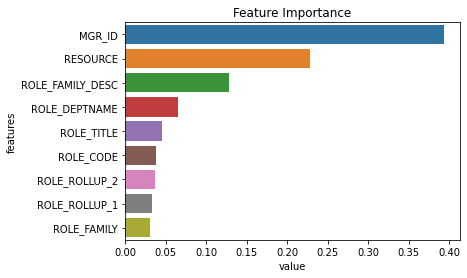

In [119]:
features=train_df_rc.columns
importance=model.feature_importances_
features=pd.DataFrame({'features':features,'value':importance})
features=features.sort_values('value',ascending=False)
sns.barplot('value','features',data=features);
plt.title('Feature Importance');

In [120]:
predictions = model.predict_proba(test_df_rc)[:,1]
save_submission(predictions, 'xgb_rc.csv')

# 5 Build model on SVD feature

In [122]:
train_svd = pd.read_csv('data/train_svd.csv')
test_svd = pd.read_csv('data/test_svd.csv')

In [123]:
train_svd.shape, test_svd.shape, y_train.shape

((32769, 72), (58921, 72), (32769,))

## 5.1 KNN with SVD

In [124]:
parameters={'n_neighbors':np.arange(1,100, 5)}
clf = RandomizedSearchCV(KNeighborsClassifier(n_jobs=-1),parameters,random_state=random_state,cv=cv,verbose=verbose,scoring=scoring,n_jobs=-1)
best_model = clf.fit(train_svd,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   34.5s finished


In [125]:
results = pd.DataFrame.from_dict(best_model.cv_results_)
results=results.sort_values('param_n_neighbors')
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.456659,0.018893,0.814999,0.094421,1,{'n_neighbors': 1},0.683686,0.708752,0.711678,0.695199,0.688302,0.697523,0.011030,10
3,1.847875,0.670771,1.563348,0.189923,6,{'n_neighbors': 6},0.774836,0.790142,0.790174,0.802106,0.796821,0.790816,0.009162,1
7,1.630743,0.761278,2.304946,0.578605,16,{'n_neighbors': 16},0.775776,0.805809,0.785608,0.791553,0.781162,0.787981,0.010312,2
5,2.093098,0.828599,2.896172,0.737450,26,{'n_neighbors': 26},0.767621,0.787773,0.778761,0.774628,0.773609,0.776478,0.006677,3
4,1.432842,0.548565,3.511169,0.441891,41,{'n_neighbors': 41},0.756356,0.776811,0.769727,0.761724,0.757368,0.764398,0.007794,4
6,1.243584,0.194949,4.611563,0.199207,56,{'n_neighbors': 56},0.748039,0.760013,0.760727,0.752137,0.751543,0.754492,0.005005,5
2,2.660249,0.570107,4.373269,0.521148,76,{'n_neighbors': 76},0.732281,0.737831,0.753871,0.732209,0.742187,0.739676,0.008021,6
9,2.578894,0.476510,3.798244,0.735977,81,{'n_neighbors': 81},0.730612,0.731773,0.751814,0.731879,0.743131,0.737842,0.008341,7
1,1.136795,0.882508,4.522303,0.451833,86,{'n_neighbors': 86},0.728424,0.728917,0.747933,0.731289,0.745360,0.736385,0.008474,8
8,1.592410,0.775914,5.041160,0.284380,91,{'n_neighbors': 91},0.724298,0.725631,0.742431,0.728516,0.744969,0.733169,0.008743,9


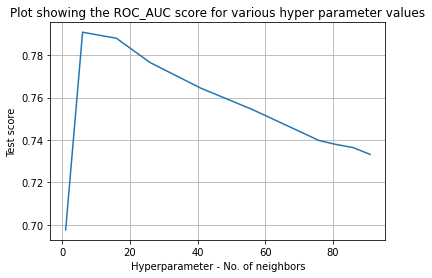

In [126]:
print_graph(results, 'param_n_neighbors', 'mean_test_score', 'Hyperparameter - No. of neighbors', 'Test score')  

In [127]:
best_c=best_model.best_params_['n_neighbors']
best_c

6

In [128]:
model = KNeighborsClassifier(n_neighbors=best_c,n_jobs=-1)
model.fit(train_svd,y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=6)

In [129]:
predictions = model.predict_proba(test_svd)[:,1]
save_submission(predictions, "knn_svd.csv")

## 5.2 SVM with SVD

In [130]:
C_val = uniform(loc=0, scale=4)
model= LinearSVC(verbose=verbose,random_state=random_state,class_weight='balanced',max_iter=2000)
parameters={'C':C_val}
clf = RandomizedSearchCV(model,parameters,random_state=random_state,cv=cv,verbose=verbose,scoring=scoring,n_jobs=-1)
best_model = clf.fit(train_svd,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.2min finished


[LibLinear]

In [131]:
best_c=best_model.best_params_['C']
best_c

3.8028572256396647

In [132]:
results = pd.DataFrame.from_dict(best_model.cv_results_)
results=results.sort_values('param_C')
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,2.228692,0.068384,0.011507,0.000900,0.232334,{'C': 0.23233444867279784},0.634839,0.636558,0.625390,0.631673,0.648453,0.635383,0.007565,10
5,5.231323,0.229664,0.012772,0.001769,0.623978,{'C': 0.6239780813448106},0.640705,0.639460,0.626744,0.635352,0.651394,0.638731,0.007999,9
4,5.203339,0.126696,0.012281,0.002006,0.624075,{'C': 0.6240745617697461},0.640705,0.639463,0.626747,0.635353,0.651395,0.638732,0.007998,8
0,13.784890,0.838090,0.011745,0.000778,1.49816,{'C': 1.49816047538945},0.645319,0.641522,0.628096,0.639863,0.652860,0.641532,0.008075,7
3,23.684437,0.270787,0.011281,0.000265,2.39463,{'C': 2.3946339367881464},0.646977,0.641498,0.628038,0.641603,0.653376,0.642298,0.008356,6
8,24.014088,0.459591,0.011044,0.001283,2.40446,{'C': 2.404460046972835},0.646977,0.641494,0.628043,0.641614,0.653371,0.642300,0.008353,5
9,24.360260,2.584804,0.007434,0.001772,2.83229,{'C': 2.832290311184182},0.647186,0.641545,0.627889,0.641841,0.653459,0.642384,0.008448,4
2,29.104267,1.682526,0.011510,0.001007,2.92798,{'C': 2.9279757672456204},0.647245,0.641560,0.627827,0.641863,0.653489,0.642397,0.008483,3
7,35.642798,1.644549,0.012067,0.000464,3.4647,{'C': 3.4647045830997407},0.647549,0.641669,0.627698,0.642045,0.653490,0.642490,0.008559,2
1,38.825137,1.242134,0.028646,0.032143,3.80286,{'C': 3.8028572256396647},0.647759,0.641743,0.627645,0.642088,0.653549,0.642557,0.008615,1


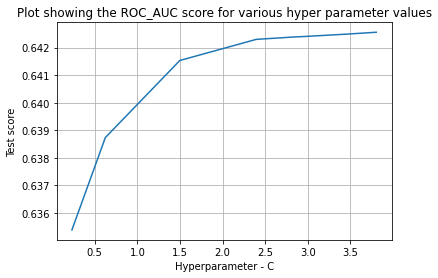

In [133]:
print_graph(results, 'param_C', 'mean_test_score', 'Hyperparameter - C', 'Test score')

In [134]:
#https://stackoverflow.com/questions/26478000/converting-linearsvcs-decision-function-to-probabilities-scikit-learn-python
model = LinearSVC(C=best_c,verbose=verbose,random_state=random_state,class_weight='balanced',max_iter=2000)
model = CalibratedClassifierCV(model)
model.fit(train_svd,y_train)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

CalibratedClassifierCV(base_estimator=LinearSVC(C=3.8028572256396647,
                                                class_weight='balanced',
                                                max_iter=2000, random_state=42,
                                                verbose=2))

In [135]:
predictions = model.predict_proba(test_svd)[:,1]
save_submission(predictions, 'svm_svd.csv')

## 5.3 Logistic Regression with SVD

In [136]:
C_val = uniform(loc=0, scale=4)
lr= LogisticRegression(verbose=verbose,random_state=random_state,class_weight='balanced',solver='lbfgs',max_iter=500,n_jobs=-1)
parameters={'C':C_val}
clf = RandomizedSearchCV(lr,parameters,random_state=random_state,cv=cv,verbose=verbose,n_iter=100,scoring=scoring,n_jobs=-1)
best_model = clf.fit(train_svd,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.9s finished


In [137]:
best_c=best_model.best_params_['C']
best_c

3.947547746402069

In [138]:
results = pd.DataFrame.from_dict(best_model.cv_results_)
results=results.sort_values('param_C')
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
72,0.793597,0.100696,0.025810,0.007258,0.0220885,{'C': 0.022088468494409597},0.604873,0.600333,0.602393,0.608164,0.630087,0.609170,0.010780,100
10,1.219796,0.131475,0.019476,0.004521,0.082338,{'C': 0.08233797718320979},0.618172,0.619258,0.615257,0.617055,0.637928,0.621534,0.008303,99
98,1.471026,0.167066,0.027469,0.004389,0.101677,{'C': 0.10167650697638075},0.619889,0.622181,0.615896,0.618293,0.639096,0.623071,0.008271,98
42,1.658208,0.109603,0.024324,0.005244,0.137554,{'C': 0.13755408446087358},0.621979,0.625304,0.617100,0.620475,0.640221,0.625016,0.008047,97
58,1.761590,0.074261,0.027399,0.006468,0.180909,{'C': 0.18090915564215226},0.624074,0.627986,0.618850,0.621867,0.641453,0.626846,0.007888,96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,5.302916,0.098177,0.023990,0.008429,3.80286,{'C': 3.8028572256396647},0.639070,0.639976,0.625161,0.635001,0.650478,0.637937,0.008180,5
34,6.140913,0.473590,0.021449,0.000513,3.86253,{'C': 3.8625281322982374},0.639170,0.640006,0.625275,0.635038,0.650431,0.637984,0.008132,3
50,6.031093,0.278328,0.022983,0.004762,3.87834,{'C': 3.8783385110582342},0.639168,0.639948,0.625290,0.635046,0.650405,0.637972,0.008115,4
11,5.032520,0.376563,0.021294,0.004814,3.87964,{'C': 3.8796394086479773},0.639160,0.640000,0.625241,0.635060,0.650471,0.637987,0.008152,2


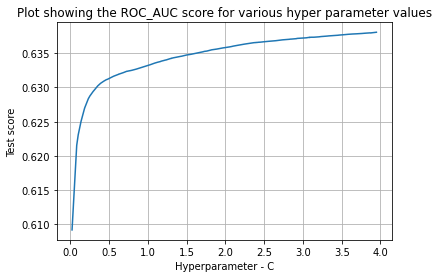

In [139]:
print_graph(results, 'param_C', 'mean_test_score', 'Hyperparameter - C', 'Test score')

In [140]:
model = LogisticRegression(C=best_c,verbose=verbose,n_jobs=-1,random_state=random_state,class_weight='balanced',solver='lbfgs')
model.fit(train_svd,y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    3.0s finished


LogisticRegression(C=3.947547746402069, class_weight='balanced', n_jobs=-1,
                   random_state=42, verbose=2)

In [141]:
predictions = model.predict_proba(test_svd)[:,1]
save_submission(predictions, 'lr_svd.csv')

## 5.4 Random Forest with SVD

In [142]:
rfc = RandomForestClassifier(random_state=random_state,class_weight='balanced',n_jobs=-1)
clf = RandomizedSearchCV(rfc,get_rf_params(),random_state=random_state,cv=cv,verbose=verbose,n_iter=100,scoring=scoring,n_jobs=-1)
best_model = clf.fit(train_svd,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   35.9s
/home/auw-mayank/.local/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 24.6min finished


In [143]:
results = pd.DataFrame(best_model.cv_results_)
results.sort_values('mean_test_score',ascending=False,inplace=True)
param_keys=['param_'+str(each) for each in get_rf_params().keys()]
param_keys.append('mean_test_score')
results[param_keys].head(10)

,param_n_estimators,param_max_depth,param_max_features,param_min_samples_split,mean_test_score
84,1000,25,5,2,0.854766
20,1000,25,3,2,0.852342
33,700,25,4,2,0.852278
22,200,25,4,10,0.851746
78,700,25,2,7,0.851114
85,1000,20,3,7,0.850986
62,500,25,3,5,0.850904
82,700,20,5,20,0.850789
79,500,25,1,10,0.848939
92,500,20,3,2,0.848604


In [144]:
n_estimators=clf.best_params_['n_estimators']
max_features=clf.best_params_['max_features']
max_depth=clf.best_params_['max_depth']
min_samples_split=clf.best_params_['min_samples_split']
n_estimators,max_features,max_depth,min_samples_split

(1000, 5, 25, 2)

In [145]:
model=RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,max_features=max_features,
                             min_samples_split=min_samples_split,
                             random_state=random_state,class_weight='balanced',n_jobs=-1)

model.fit(train_svd,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=25, max_features=5,
                       n_estimators=1000, n_jobs=-1, random_state=42)

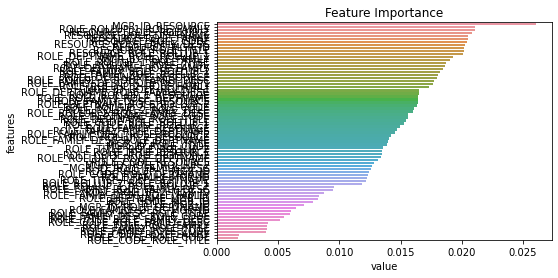

In [147]:
features=train_svd.columns
importance=model.feature_importances_
features=pd.DataFrame({'features':features,'value':importance})
features=features.sort_values('value',ascending=False)
sns.barplot('value','features',data=features);
plt.title('Feature Importance');

In [148]:
predictions = model.predict_proba(test_svd)[:,1]
save_submission(predictions, 'rf_svd.csv')

## 5.5 Xgboost with SVD

In [149]:
xgb = XGBClassifier()
clf = RandomizedSearchCV(xgb,get_xgb_params(),random_state=random_state,cv=cv,verbose=verbose,n_iter=100,scoring=scoring,n_jobs=-1)
best_model=clf.fit(train_svd,y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   53.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 29.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 53.5min finished


In [150]:
results = pd.DataFrame(best_model.cv_results_)
results.sort_values('mean_test_score',ascending=False,inplace=True)
param_keys=['param_'+str(each) for each in get_xgb_params().keys()]
param_keys.append('mean_test_score')
results[param_keys].head(10)

,param_n_estimators,param_learning_rate,param_subsample,param_max_depth,param_colsample_bytree,param_min_child_weight,mean_test_score
62,500,0.0663892,0.328153,9,0.375583,3,0.857269
18,1000,0.048135,0.665922,9,0.330898,2,0.856856
96,500,0.0979629,0.98664,7,0.891897,1,0.856098
44,1000,0.060484,0.606429,6,0.642032,2,0.855896
8,750,0.0686033,0.683264,6,0.304614,4,0.855817
97,750,0.232385,0.907694,6,0.374271,1,0.853594
49,500,0.160277,0.393098,8,0.636333,2,0.848866
80,1000,0.385564,0.905351,3,0.820639,1,0.848727
53,200,0.540096,0.928319,6,0.27956,1,0.847864
78,1000,0.576551,0.94023,6,0.943892,4,0.844565


In [151]:
colsample_bytree = clf.best_params_['colsample_bytree']
learning_rate=clf.best_params_['learning_rate']
max_depth=clf.best_params_['max_depth']
min_child_weight=clf.best_params_['min_child_weight']
n_estimators=clf.best_params_['n_estimators']
subsample=clf.best_params_['subsample']
colsample_bytree,learning_rate,max_depth,min_child_weight,n_estimators,subsample

(0.375582952639944, 0.06638916390452139, 9, 3, 500, 0.32815266747473193)

In [152]:
model = XGBClassifier(colsample_bytree=colsample_bytree,learning_rate=learning_rate,max_depth=max_depth,
                     min_child_weight=min_child_weight,n_estimators=n_estimators,subsample=subsample,n_jobs=-1)

model.fit(train_svd,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.375582952639944, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.06638916390452139, max_delta_step=0, max_depth=9,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.32815266747473193, tree_method='exact',
              validate_parameters=1, verbosity=None)

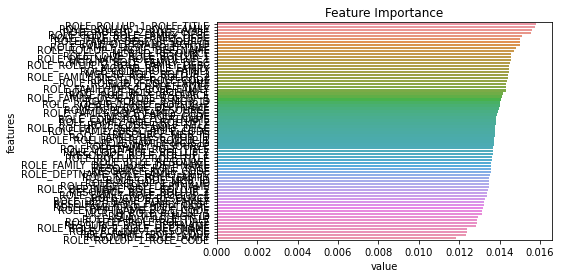

In [153]:
features=train_svd.columns
importance=model.feature_importances_
features=pd.DataFrame({'features':features,'value':importance})
features=features.sort_values('value',ascending=False)
sns.barplot('value','features',data=features);
plt.title('Feature Importance');

In [154]:
predictions = model.predict_proba(test_svd)[:,1]
save_submission(predictions, 'xgb_svd.csv')